In [15]:
import os
import sys
import deepchem as dc
import pandas as pd
from rdkit import Chem
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sys.path.append(os.path.abspath("."))  
warnings.filterwarnings("ignore")

In [3]:
def dc_to_df(dataset):
    """Convert a DeepChem dataset to pandas DataFrame"""
    return pd.DataFrame({
        "smiles": dataset.ids,
        **{f"label_{i}": dataset.y[:, i] for i in range(dataset.y.shape[1])}
    })

In [4]:
tasks, datasets, transformers = dc.molnet.load_lipo(featurizer="Raw", split="scaffold")
train, valid, test = datasets

df_train = dc_to_df(train)
df_valid = dc_to_df(valid)
df_test = dc_to_df(test)

print("Train shape:", df_train.shape)
df_train.head()

'split' is deprecated.  Use 'splitter' instead.


Train shape: (3360, 2)


,smiles,label_0
0,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,-1.703482
1,Cc1ccc(NC(=N)N)cc1C,-2.892589
2,CC(C)C(=O)NCCNCC(O)COc1ccc(O)cc1,-1.909924
3,C[C@@](O)(C(=O)Nc1ccc(cc1Cl)S(=O)(=O)NCC=C)C(F...,0.749051
4,CC(C)NCC(O)COc1ccccc1OCC=C,-1.620905


In [5]:
os.makedirs("../data", exist_ok=True)

df_train.to_csv("../data/lipo_train.csv", index=False)
df_valid.to_csv("../data/lipo_valid.csv", index=False)
df_test.to_csv("../data/lipo_test.csv", index=False)

print("✅ Lipophilicity splits saved to ../data/")

✅ Lipophilicity splits saved to ../data/


In [7]:
import deepchem.molnet as molnet
print(dir(molnet))

['TransformerGenerator', '_MolnetLoader', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'dnasim', 'featurizers', 'load_Platinum_Adsorption', 'load_bace_classification', 'load_bace_regression', 'load_bandgap', 'load_bbbc001', 'load_bbbc002', 'load_bbbc003', 'load_bbbc004', 'load_bbbc005', 'load_bbbp', 'load_cell_counting', 'load_chembl', 'load_chembl25', 'load_clearance', 'load_clintox', 'load_delaney', 'load_factors', 'load_freesolv', 'load_function', 'load_hiv', 'load_hopv', 'load_hppb', 'load_kaggle', 'load_kinase', 'load_lipo', 'load_mp_formation_energy', 'load_mp_metallicity', 'load_muv', 'load_nci', 'load_pcba', 'load_pdbbind', 'load_perovskite', 'load_ppb', 'load_qm7', 'load_qm8', 'load_qm9', 'load_sampl', 'load_sider', 'load_sweet', 'load_thermosol', 'load_tox21', 'load_toxcast', 'load_uspto', 'load_uv', 'load_zinc15', 'motif_density', 'simple_motif_embedding', 'simulate_motif_counting', 'simulate_motif_dens

In [6]:
import os
sns.set(style="whitegrid")
DATA_DIR = "./data"
properties = ["lipo", "esol", "bbbp", "tox21"]

In [7]:
for prop in properties:
    df = pd.read_csv(os.path.join(DATA_DIR, prop, "train.csv"))
    print(f"{prop.upper()} - rows: {len(df)}, columns: {df.columns.tolist()}")

LIPO - rows: 3360, columns: ['smiles', 'label_0']
ESOL - rows: 902, columns: ['smiles', 'label_0']
BBBP - rows: 1631, columns: ['smiles', 'label_0']
TOX21 - rows: 6258, columns: ['smiles', 'label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 'label_8', 'label_9', 'label_10', 'label_11']


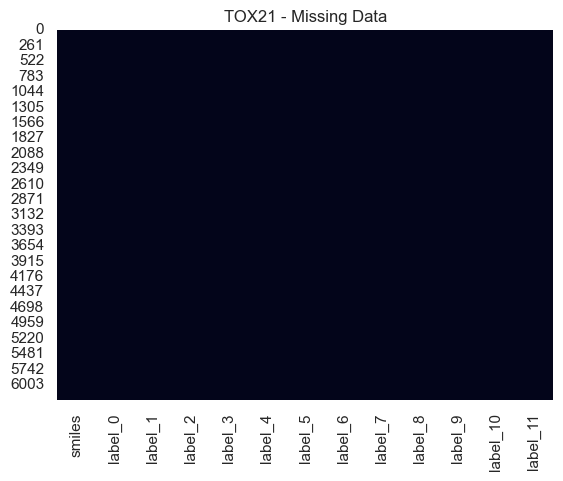

In [10]:
sns.heatmap(df.isna(), cbar=False)
plt.title(f"{prop.upper()} - Missing Data")
plt.show()

In [11]:
def smiles_validity(smiles):
    return Chem.MolFromSmiles(smiles) is not None

df["valid_smiles"] = df["smiles"].apply(smiles_validity)
print(f"Valid SMILES: {df['valid_smiles'].sum()} / {len(df)}")

[22:52:17] WARNING: not removing hydrogen atom without neighbors


Valid SMILES: 6258 / 6258


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def label_analysis(df, prop_name):
    """
    Analyze labels of a dataset and plot distributions.
    df: pandas DataFrame with 'smiles' + 'label_...' columns
    prop_name: string, dataset name
    """
    label_cols = [c for c in df.columns if "label" in c]

    for label in label_cols:
        print(f"\n=== {prop_name} - {label} ===")
        
        missing = df[label].isna().sum()
        print(f"Missing values: {missing} / {len(df)}")

        # Determine if regression or classification
        if df[label].dtype in [np.float64, np.int64] and df[label].nunique() > 2:
            print(df[label].describe())
            plt.figure(figsize=(6,4))
            sns.histplot(df[label].dropna(), kde=True, bins=30)
            plt.title(f"{prop_name} - {label} Distribution (Regression)")
            plt.xlabel(label)
            plt.ylabel("Count")
            plt.show()
        else:
            counts = df[label].value_counts(dropna=False)
            print("Class distribution:")
            print(counts)
            plt.figure(figsize=(4,4))
            sns.barplot(x=counts.index.astype(str), y=counts.values)
            plt.title(f"{prop_name} - {label} Class Distribution (Classification)")
            plt.xlabel(label)
            plt.ylabel("Count")
            plt.show()

Shape: (3360, 2)
Columns: ['smiles', 'label_0']
                                              smiles   label_0
0                  CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1 -1.703482
1                                Cc1ccc(NC(=N)N)cc1C -2.892589
2                   CC(C)C(=O)NCCNCC(O)COc1ccc(O)cc1 -1.909924
3  C[C@@](O)(C(=O)Nc1ccc(cc1Cl)S(=O)(=O)NCC=C)C(F...  0.749051
4                         CC(C)NCC(O)COc1ccccc1OCC=C -1.620905

Valid SMILES: 3360 / 3360

Missing values per column:
smiles          0
label_0         0
valid_smiles    0
dtype: int64

Detected label columns: ['label_0']

Stats for label_0:
count    3.360000e+03
mean     7.884698e-15
std      1.000149e+00
min     -3.024712e+00
25%     -6.299829e-01
50%      1.462397e-01
75%      7.738239e-01
max      1.929900e+00
Name: label_0, dtype: float64


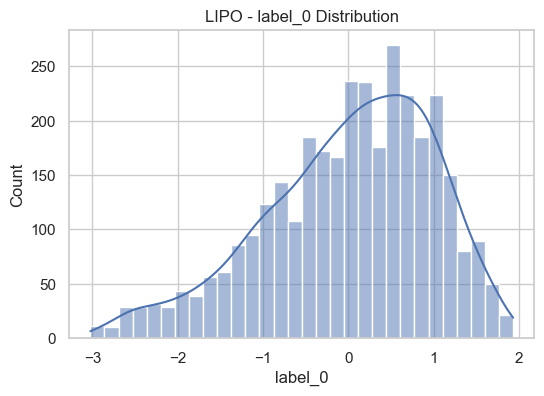

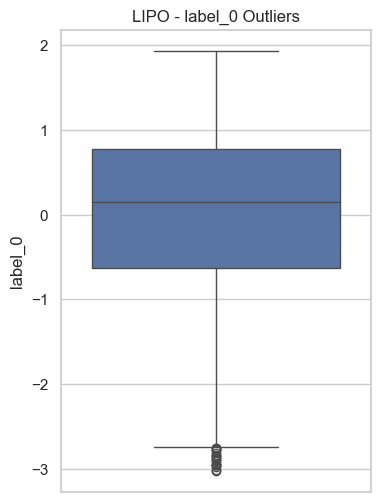

In [17]:
# === Fix: dynamically detect label column ===

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem

# Load dataset
df = pd.read_csv("../data/lipo/train.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

# 1. Check SMILES validity
def check_smiles_validity(smiles):
    return Chem.MolFromSmiles(smiles) is not None

df["valid_smiles"] = df["smiles"].apply(check_smiles_validity)
print("\nValid SMILES:", df["valid_smiles"].sum(), "/", len(df))

# 2. Check missing values
print("\nMissing values per column:")
print(df.isna().sum())

# 3. Detect label column (anything except "smiles" or "valid_smiles")
label_cols = [col for col in df.columns if col not in ["smiles", "valid_smiles"]]
print("\nDetected label columns:", label_cols)

# Assume single label for LIPO
label_col = label_cols[0]

# 4. Label stats
print(f"\nStats for {label_col}:")
print(df[label_col].describe())

# 5. Distribution plot
plt.figure(figsize=(6,4))
sns.histplot(df[label_col], bins=30, kde=True)
plt.title(f"LIPO - {label_col} Distribution")
plt.xlabel(label_col)
plt.ylabel("Count")
plt.show()

# 6. Outlier check (boxplot)
plt.figure(figsize=(4,6))
sns.boxplot(y=df[label_col])
plt.title(f"LIPO - {label_col} Outliers")
plt.ylabel(label_col)
plt.show()

Shape: (902, 2)
Columns: ['smiles', 'label_0']
                 smiles   label_0
0  CC(C)=CCCC(C)=CC(=O)  0.390413
1                CCCC=C  0.090421
2        CCCCCCCCCCCCCC -2.464346
3               CC(C)Cl  0.704920
4              CCC(C)CO  1.159746

Valid SMILES: 902 / 902

Missing values per column:
smiles          0
label_0         0
valid_smiles    0
dtype: int64

Detected label columns: ['label_0']

Stats for label_0:
count    9.020000e+02
mean    -3.150966e-16
std      1.000555e+00
min     -4.225588e+00
25%     -6.208493e-01
50%      1.201785e-01
75%      7.279036e-01
max      2.151654e+00
Name: label_0, dtype: float64


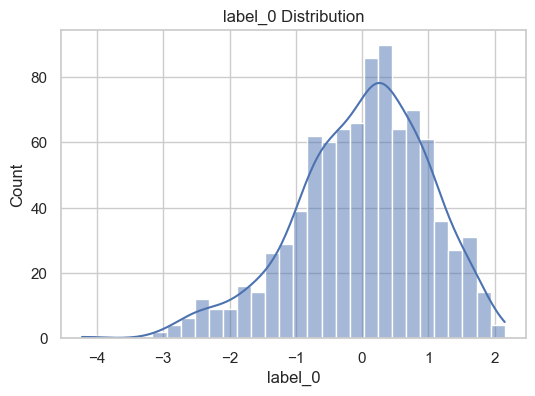

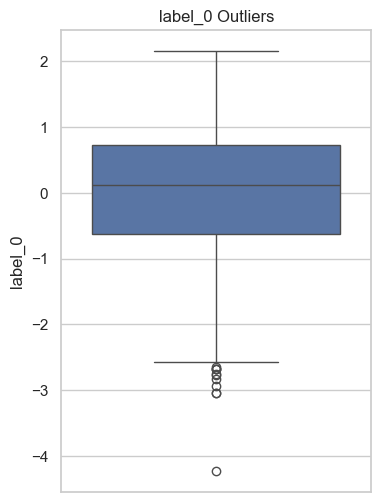

In [18]:
# === Generalized ADMET Dataset EDA ===

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/esol/train.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

# 1. Check SMILES validity
def check_smiles_validity(smiles):
    return Chem.MolFromSmiles(smiles) is not None

df["valid_smiles"] = df["smiles"].apply(check_smiles_validity)
print("\nValid SMILES:", df["valid_smiles"].sum(), "/", len(df))

# 2. Check missing values
print("\nMissing values per column:")
print(df.isna().sum())

# 3. Detect label columns (all starting with "label")
label_cols = [col for col in df.columns if col.startswith("label")]
print("\nDetected label columns:", label_cols)

# 4. If single label → regression/classification EDA
if len(label_cols) == 1:
    label_col = label_cols[0]
    print(f"\nStats for {label_col}:")
    print(df[label_col].describe())

    # Histogram
    plt.figure(figsize=(6,4))
    sns.histplot(df[label_col], bins=30, kde=True)
    plt.title(f"{label_col} Distribution")
    plt.xlabel(label_col)
    plt.ylabel("Count")
    plt.show()

    # Boxplot
    plt.figure(figsize=(4,6))
    sns.boxplot(y=df[label_col])
    plt.title(f"{label_col} Outliers")
    plt.ylabel(label_col)
    plt.show()

# 5. If multiple labels → multi-task classification analysis
else:
    label_stats = df[label_cols].describe().T
    print("\nMulti-task label stats:")
    print(label_stats)

    # Count missing per label
    missing_counts = df[label_cols].isna().sum()
    print("\nMissing label counts:")
    print(missing_counts)

    # Plot class balance for each label
    fig, axes = plt.subplots(3, 4, figsize=(16,10))
    axes = axes.ravel()
    for i, col in enumerate(label_cols):
        sns.countplot(x=df[col], ax=axes[i])
        axes[i].set_title(col)
    plt.tight_layout()
    plt.show()

Shape: (1631, 2)
Columns: ['smiles', 'label_0']
                                              smiles  label_0
0           C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl      1.0
1                                 C[C@H](N)Cc1ccccc1      1.0
2  C[S](=O)(=O)c1ccc(cc1)[C@@H](O)[C@@H](CO)NC(=O...      1.0
3                                CC(N)COc1c(C)cccc1C      1.0
4                                       c1(ccccc1)CC      1.0

Valid SMILES: 1631 / 1631

Missing values per column:
smiles          0
label_0         0
valid_smiles    0
dtype: int64

Detected label columns: ['label_0']

Stats for label_0:
count    1631.000000
mean        0.822195
std         0.382466
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: label_0, dtype: float64


[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not removing hydrogen atom without neighbors
[07:36:41] WARNING: not r

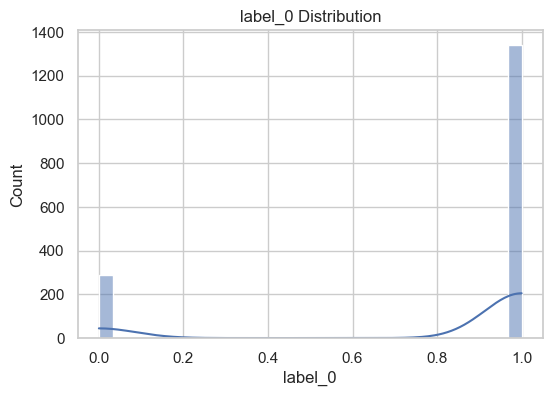

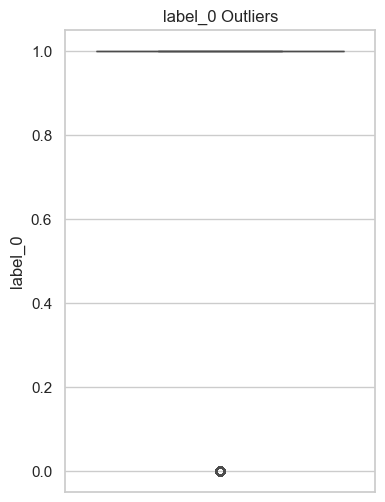

In [19]:
# === Generalized ADMET Dataset EDA ===

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (change folder name for other properties)
df = pd.read_csv("../data/bbbp/train.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

# 1. Check SMILES validity
def check_smiles_validity(smiles):
    return Chem.MolFromSmiles(smiles) is not None

df["valid_smiles"] = df["smiles"].apply(check_smiles_validity)
print("\nValid SMILES:", df["valid_smiles"].sum(), "/", len(df))

# 2. Check missing values
print("\nMissing values per column:")
print(df.isna().sum())

# 3. Detect label columns (all starting with "label")
label_cols = [col for col in df.columns if col.startswith("label")]
print("\nDetected label columns:", label_cols)

# 4. If single label → regression/classification EDA
if len(label_cols) == 1:
    label_col = label_cols[0]
    print(f"\nStats for {label_col}:")
    print(df[label_col].describe())

    # Histogram
    plt.figure(figsize=(6,4))
    sns.histplot(df[label_col], bins=30, kde=True)
    plt.title(f"{label_col} Distribution")
    plt.xlabel(label_col)
    plt.ylabel("Count")
    plt.show()

    # Boxplot
    plt.figure(figsize=(4,6))
    sns.boxplot(y=df[label_col])
    plt.title(f"{label_col} Outliers")
    plt.ylabel(label_col)
    plt.show()

# 5. If multiple labels → multi-task classification analysis
else:
    label_stats = df[label_cols].describe().T
    print("\nMulti-task label stats:")
    print(label_stats)

    # Count missing per label
    missing_counts = df[label_cols].isna().sum()
    print("\nMissing label counts:")
    print(missing_counts)

    # Plot class balance for each label
    fig, axes = plt.subplots(3, 4, figsize=(16,10))
    axes = axes.ravel()
    for i, col in enumerate(label_cols):
        sns.countplot(x=df[col], ax=axes[i])
        axes[i].set_title(col)
    plt.tight_layout()
    plt.show()

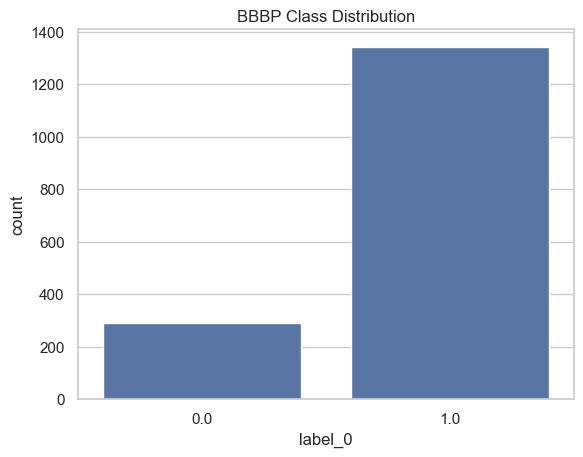

In [20]:
sns.countplot(x=df["label_0"])
plt.title("BBBP Class Distribution")
plt.show()

Shape: (6258, 13)
Columns: ['smiles', 'label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 'label_8', 'label_9', 'label_10', 'label_11']
                                     smiles  label_0  label_1  label_2  \
0                 CC(O)(P(=O)(O)O)P(=O)(O)O      0.0      0.0      0.0   
1      CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C      0.0      0.0      0.0   
2             OC[C@H](O)[C@@H](O)[C@H](O)CO      0.0      0.0      0.0   
3  CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]      0.0      0.0      0.0   
4                         CC(C)COC(=O)C(C)C      0.0      0.0      0.0   

   label_3  label_4  label_5  label_6  label_7  label_8  label_9  label_10  \
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0       

[07:40:25] WARNING: not removing hydrogen atom without neighbors



Valid SMILES: 6258 / 6258

Detected label columns: ['label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 'label_8', 'label_9', 'label_10', 'label_11']

Missing values per label:
label_0     0
label_1     0
label_2     0
label_3     0
label_4     0
label_5     0
label_6     0
label_7     0
label_8     0
label_9     0
label_10    0
label_11    0
dtype: int64

Class balance per label:
label_0:
   0.0: 6008 (96.0%)
   1.0: 250 (4.0%)

label_1:
   0.0: 6065 (96.9%)
   1.0: 193 (3.1%)

label_2:
   0.0: 5669 (90.6%)
   1.0: 589 (9.4%)

label_3:
   0.0: 6050 (96.7%)
   1.0: 208 (3.3%)

label_4:
   0.0: 5612 (89.7%)
   1.0: 646 (10.3%)

label_5:
   0.0: 5959 (95.2%)
   1.0: 299 (4.8%)

label_6:
   0.0: 6126 (97.9%)
   1.0: 132 (2.1%)

label_7:
   0.0: 5540 (88.5%)
   1.0: 718 (11.5%)

label_8:
   0.0: 6062 (96.9%)
   1.0: 196 (3.1%)

label_9:
   0.0: 5977 (95.5%)
   1.0: 281 (4.5%)

label_10:
   0.0: 5547 (88.6%)
   1.0: 711 (11.4%)

label_11:
   0.0: 5982 (9

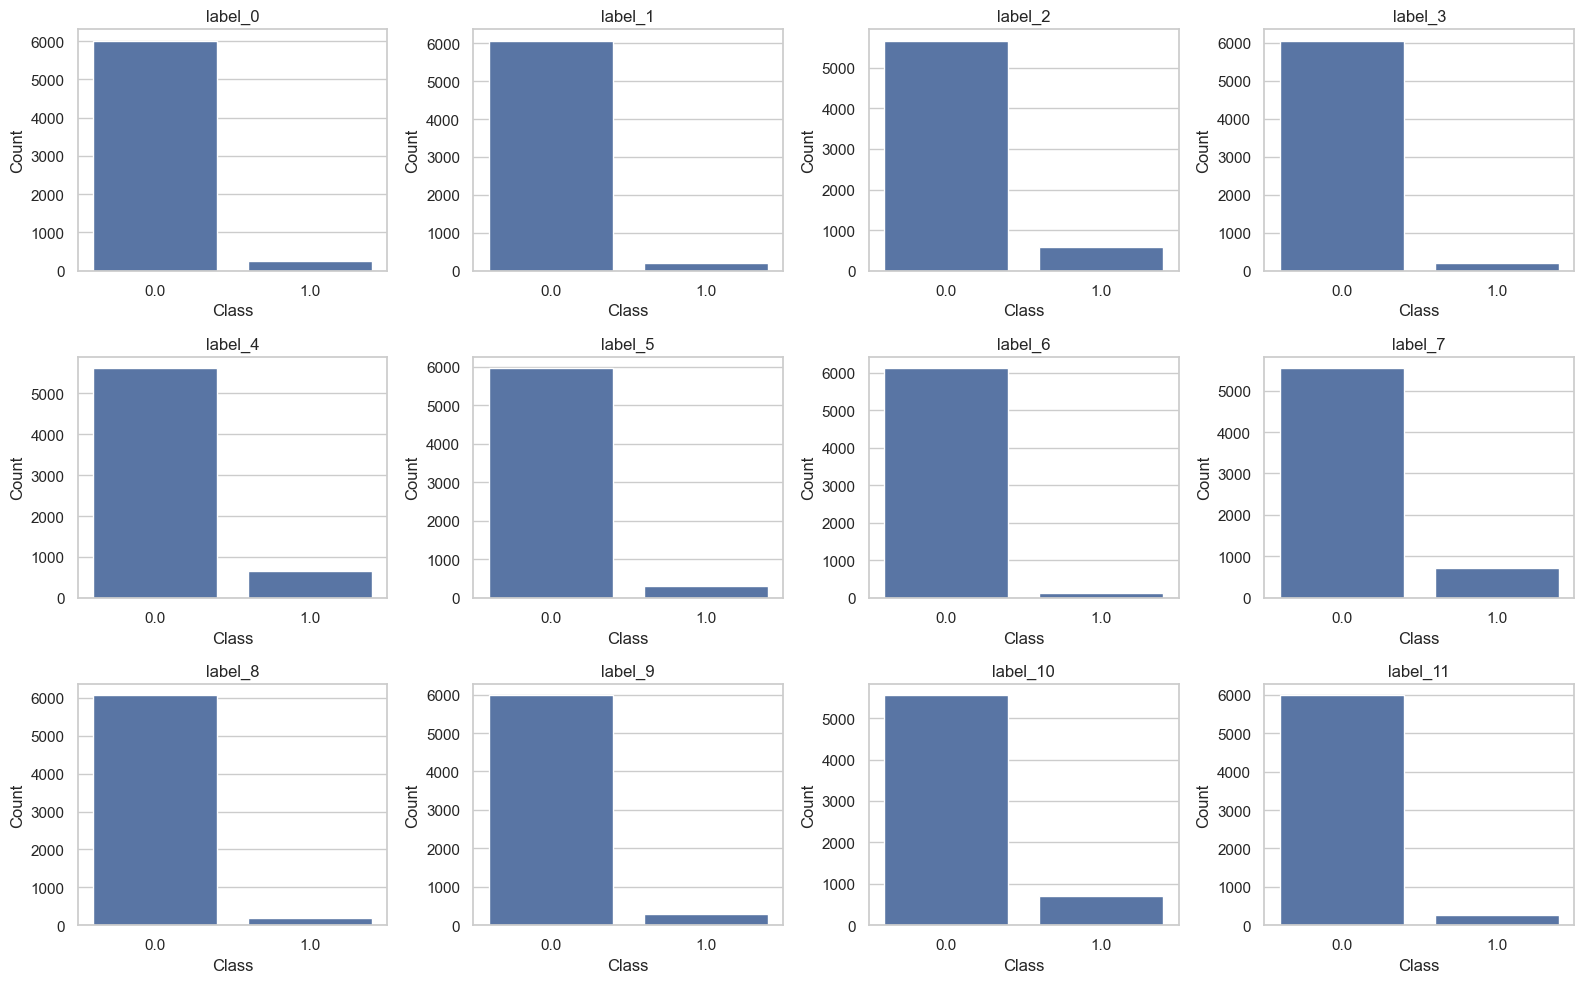

In [21]:
# === Tox21 Multi-task Classification EDA ===

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Tox21 dataset (use train.csv / valid.csv / test.csv as needed)
df = pd.read_csv("../data/tox21/train.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

# 1. Validate SMILES
def check_smiles_validity(smiles):
    return Chem.MolFromSmiles(smiles) is not None

df["valid_smiles"] = df["smiles"].apply(check_smiles_validity)
print("\nValid SMILES:", df["valid_smiles"].sum(), "/", len(df))

# 2. Identify label columns
label_cols = [col for col in df.columns if col.startswith("label")]
print("\nDetected label columns:", label_cols)

# 3. Missing values per label
print("\nMissing values per label:")
print(df[label_cols].isna().sum())

# 4. Class balance analysis
print("\nClass balance per label:")
for col in label_cols:
    counts = df[col].value_counts(dropna=True)
    total = counts.sum()
    percents = counts / total * 100
    print(f"{col}:")
    for val, cnt in counts.items():
        print(f"   {val}: {cnt} ({percents[val]:.1f}%)")
    print()

# 5. Visualize distributions
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.ravel()

for i, col in enumerate(label_cols):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("Class")
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [9]:
from src.eda_utils import ADMETEDA
df_lipo = pd.read_csv("./data/lipo/train.csv")

In [10]:
eda_lipo = ADMETEDA(df_lipo, dataset_name="Lipo")


===== EDA Report for Lipo =====
Shape: (3360, 2)
Columns: ['smiles', 'label_0']
[Lipo] Valid SMILES: 3360/3360 (100.0%)

[Lipo] Missing values summary:
smiles          0
label_0         0
valid_smiles    0
dtype: int64

[Lipo] Regression label stats:
label_0:
count    3.360000e+03
mean     7.884698e-15
std      1.000149e+00
min     -3.024712e+00
25%     -6.299829e-01
50%      1.462397e-01
75%      7.738239e-01
max      1.929900e+00
Name: label_0, dtype: float64



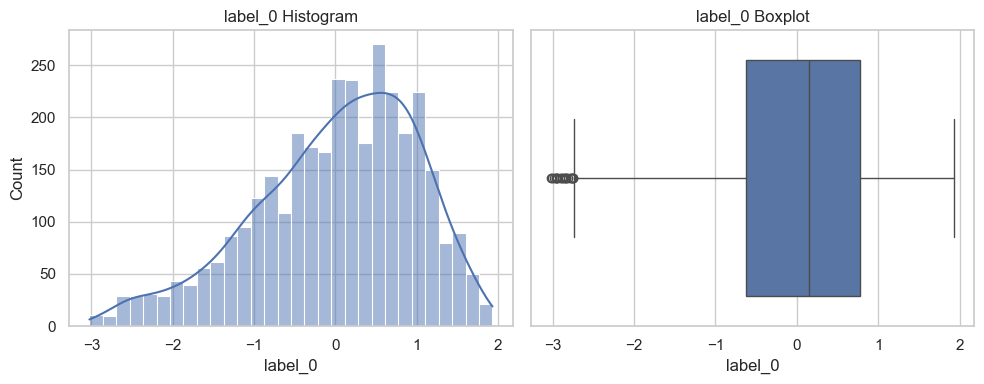


[Lipo] Correlation matrix:
         label_0
label_0      1.0


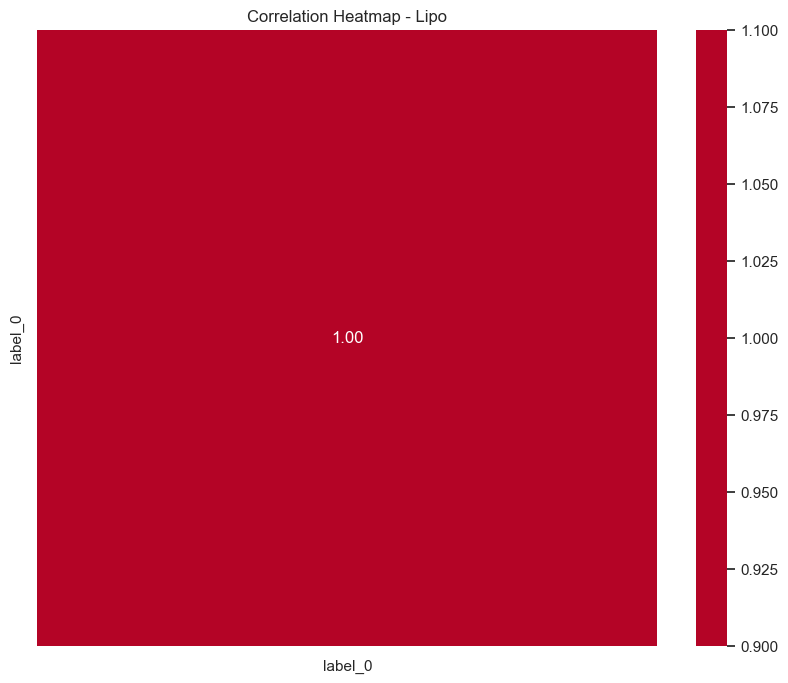

In [11]:
eda_lipo.run_full_eda()

In [17]:
import sys
import os

sys.path.append(os.path.abspath("."))

from src.eda_utils import MultiTaskBinaryClassificationEDA

# Load dataset
import pandas as pd
df_tox21 = pd.read_csv("./data/tox21/tox21_train.csv")

# Run EDA
eda_tox21 = MultiTaskBinaryClassificationEDA(df_tox21, dataset_name="Tox21")
eda_tox21.run_eda()

ImportError: cannot import name 'MultiTaskBinaryClassificationEDA' from 'src.eda_utils' (/Users/aryandahiya/Desktop/PH421/src/eda_utils.py)

In [18]:
import os
os.getcwd()

'/Users/aryandahiya/Desktop/PH421'

In [19]:
import sys
print(sys.path)  # Check if your PH421 folder or parent directory is in sys.path

['/opt/homebrew/Cellar/python@3.10/3.10.18_1/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/opt/homebrew/Cellar/python@3.10/3.10.18_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/opt/homebrew/Cellar/python@3.10/3.10.18_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/aryandahiya/Desktop/PH421/.phenv/lib/python3.10/site-packages', '/var/folders/gw/1l5px9bx4rj26hgrvvwkkhf40000gn/T/tmpr0j60scs', '/Users/aryandahiya/Desktop/PH421', '/Users/aryandahiya/Desktop/PH421']



===== Multi-Task Binary Classification EDA Report: Tox21 =====
Shape: (6258, 13)
Columns: ['smiles', 'label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 'label_8', 'label_9', 'label_10', 'label_11']


[09:33:48] WARNING: not removing hydrogen atom without neighbors


[Tox21] Valid SMILES: 6258/6258 (100.0%)

[Tox21] Missing values summary:
smiles          0
label_0         0
label_1         0
label_2         0
label_3         0
label_4         0
label_5         0
label_6         0
label_7         0
label_8         0
label_9         0
label_10        0
label_11        0
valid_smiles    0
dtype: int64

[Tox21] Label distribution for label_0:
0.0: 6008 (96.0%)
1.0: 250 (4.0%)
⚠️ Imbalance detected in label_0

[Tox21] Label distribution for label_1:
0.0: 6065 (96.9%)
1.0: 193 (3.1%)
⚠️ Imbalance detected in label_1

[Tox21] Label distribution for label_2:
0.0: 5669 (90.6%)
1.0: 589 (9.4%)
⚠️ Imbalance detected in label_2

[Tox21] Label distribution for label_3:
0.0: 6050 (96.7%)
1.0: 208 (3.3%)
⚠️ Imbalance detected in label_3

[Tox21] Label distribution for label_4:
0.0: 5612 (89.7%)
1.0: 646 (10.3%)
⚠️ Imbalance detected in label_4

[Tox21] Label distribution for label_5:
0.0: 5959 (95.2%)
1.0: 299 (4.8%)
⚠️ Imbalance detected in label_5

[Tox21] Lab

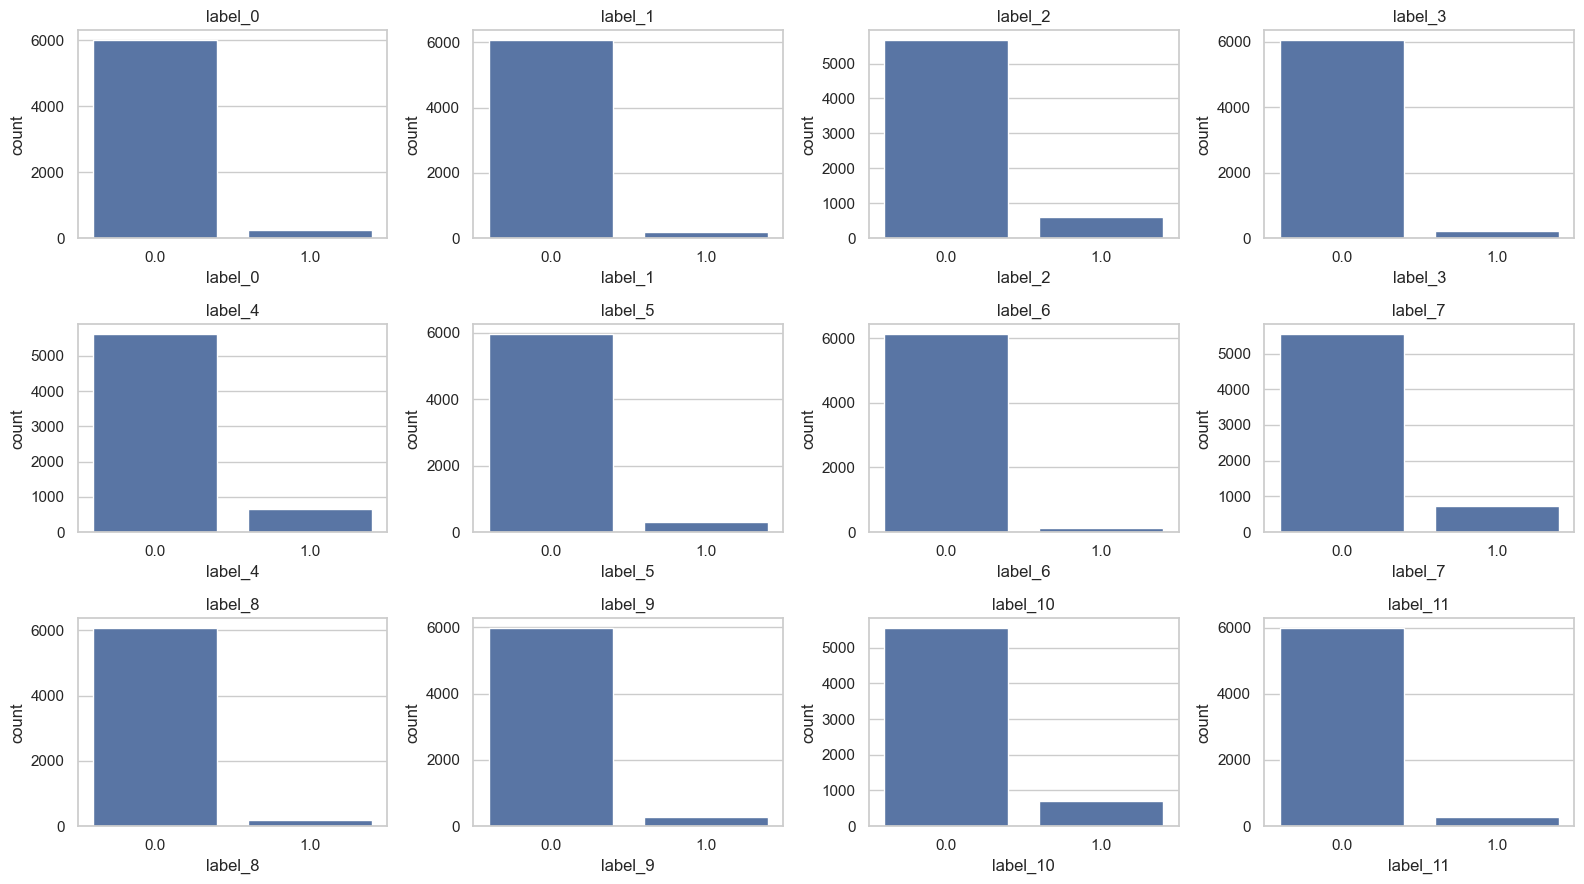


[Tox21] Correlation matrix:
           label_0   label_1   label_2   label_3   label_4   label_5  \
label_0   1.000000  0.558283  0.009697 -0.005960  0.204334  0.187657   
label_1   0.558283  1.000000 -0.003688  0.033955  0.176429  0.267706   
label_2   0.009697 -0.003688  1.000000  0.117303  0.173029  0.086869   
label_3  -0.005960  0.033955  0.117303  1.000000  0.013268  0.079666   
label_4   0.204334  0.176429  0.173029  0.013268  1.000000  0.468166   
label_5   0.187657  0.267706  0.086869  0.079666  0.468166  1.000000   
label_6  -0.007230  0.166783  0.036471  0.010004  0.005022  0.123527   
label_7   0.028974  0.066288  0.217086  0.134640  0.103627  0.145026   
label_8   0.052326  0.153650  0.212242  0.017838  0.186244  0.196281   
label_9  -0.028470  0.063975  0.093950  0.084629  0.015199  0.125075   
label_10  0.016961  0.061375  0.251915  0.166769  0.166501  0.226701   
label_11  0.027715  0.168755  0.141323  0.094761  0.078039  0.181752   

           label_6   label_7   lab

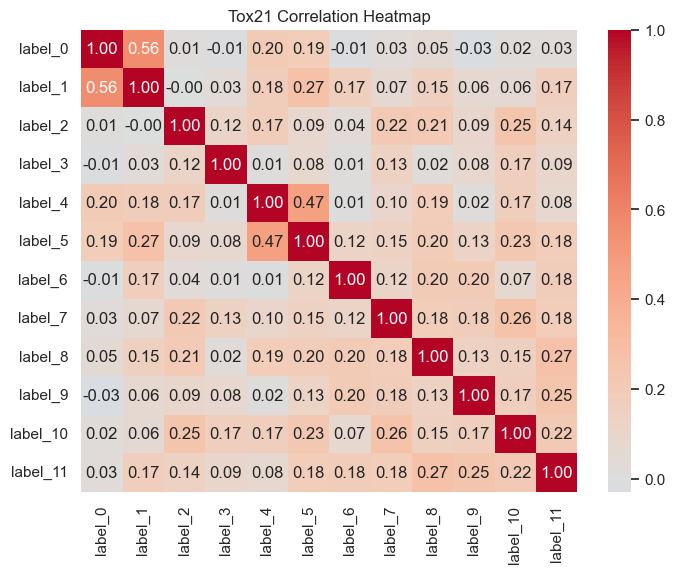

In [22]:
import importlib.util
import sys
from pathlib import Path

# Path to your eda_utils.py
module_path = Path("./src/eda_utils.py").resolve()  # adjust "../src" if notebook is elsewhere

spec = importlib.util.spec_from_file_location("eda_utils", str(module_path))
eda_utils = importlib.util.module_from_spec(spec)
sys.modules["eda_utils"] = eda_utils
spec.loader.exec_module(eda_utils)

# Now you can access classes
MultiTaskBinaryClassificationEDA = eda_utils.MultiTaskBinaryClassificationEDA

# Example usage
import pandas as pd
df_tox21 = pd.read_csv("./data/tox21/train.csv")
eda_tox21 = MultiTaskBinaryClassificationEDA(df_tox21, dataset_name="Tox21")
eda_tox21.run_eda()